# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [52]:
#carregando as bases de dados
X_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/df_x_train.csv',index_col = 'id')
X_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/df_x_test.csv',index_col = 'id')
Y_train = pd.read_csv("UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt", header= None)[0]
Y_test = pd.read_csv("UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt", header= None)[0]
#Carregando os nomes das variáveis
features = pd.read_csv("./UCI HAR Dataset/UCI HAR Dataset/features.txt",  header= None, sep=' ' , usecols=[1])[1]

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [54]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=.25, random_state=1729)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [55]:
%%time

#ajustando uma árvore de decisão com nprofundidade máxima = 4
clf = DecisionTreeClassifier(random_state=2360873,max_depth = 4).fit(x_train, y_train)

CPU times: total: 1.03 s
Wall time: 1.13 s


In [56]:
#Verificando as variáveis mais importantes

df_feature_importances = pd.DataFrame(clf.feature_importances_, index = x_train.columns, columns = ['importances'])
df_feature_importances = df_feature_importances[df_feature_importances.importances != 0]
df_feature_importances.sort_values(by = 'importances')
df_feature_importances

,importances
tGravityAcc-energy()-X,0.280288
tGravityAcc-energy()-Y,0.011366
"tGravityAcc-arCoeff()-Z,2",0.124594
tBodyGyro-min()-X,0.005917
"tBodyGyro-correlation()-Y,Z",0.017853
tBodyAccMag-std(),0.134381
fBodyAcc-mad()-X,0.253431
"angle(Y,gravityMean)",0.172169


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [57]:
%%time
#ajustando uma árvore de decisão com nprofundidade máxima = 4
clf = DecisionTreeClassifier(random_state=2360873,max_depth = 4).fit(x_train[['tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-arCoeff()-Z,2']], y_train)

CPU times: total: 0 ns
Wall time: 11 ms


In [58]:
#Calculando os ccp_alphas.
caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(x_train[['tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-arCoeff()-Z,2']], y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities
#Certificando que são apenas valores positivos
ccp_alphas = [ccp_alpha for ccp_alpha in ccp_alphas if ccp_alpha >= 0]
#Selecionando apenas valores únicos
ccp_alphas = np.unique(ccp_alphas)


In [59]:
%%time
#Rodando uma árvore para cada ccp_alpha de ccp_alphas, inserindo cada árvore em uma lista
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(x_train[['tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-arCoeff()-Z,2']], y_train)
    clfs.append(clf)

CPU times: total: 9.58 s
Wall time: 10.9 s


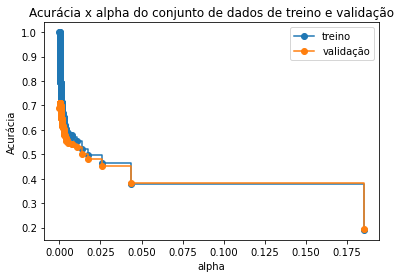

In [61]:
#Calculando a acurácia de cada árvore na base de treinamento e de validação
train_scores = [clf.score(x_train[['tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-arCoeff()-Z,2']], y_train) for clf in clfs]
valid_scores = [clf.score(x_valid[['tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-arCoeff()-Z,2']], y_valid) for clf in clfs]
#Montando um gráfico da acurácia em função do ccp_alpha na base de validação e na base de treino
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [62]:
#Seleciona a árvore com maior acurácia na base de validação (em caso de empate pega a com menor ccp_alpha)
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 71.11


DecisionTreeClassifier(ccp_alpha=0.00044450134061604484, random_state=2360873)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia: 51.34


C:\Users\rodpr\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


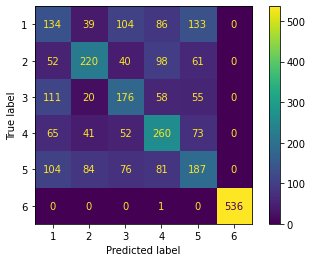

In [63]:
#Calculando a acurácia da melhor árvore na base de teste
acuracia_teste = melhor_arvore.score(X_test[['tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-arCoeff()-Z,2']], Y_test)
print(f'Acurácia: {acuracia_teste*100:.2f}')
#Plotando a matriz confusão
plot_confusion_matrix(melhor_arvore, X_test[['tGravityAcc-energy()-X','tGravityAcc-energy()-Y','tGravityAcc-arCoeff()-Z,2']], Y_test);

A acurácia do modelo caiu 20% em relação à base de validação. Com as variáveis escolhidas o modelo consegue prever com quase 100% de certeza se a pessoa está deitada (atividade 6) mas não é bem menos eficiente para as demais atividades.